<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-up-the-problem" data-toc-modified-id="Setting-up-the-problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting up the problem</a></span></li><li><span><a href="#Monte-Carlo-simulation-of-the-neuron-firing" data-toc-modified-id="Monte-Carlo-simulation-of-the-neuron-firing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monte Carlo simulation of the neuron firing</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Block-structured-matrix-$\mathbf{J}$" data-toc-modified-id="Block-structured-matrix-$\mathbf{J}$-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Block structured matrix $\mathbf{J}$</a></span></li></ul></li></ul></li></ul></div>

In [66]:
# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Useful packages
import itertools

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn, useful for graphics
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'grid.color' : 'a6a6a6',
    'lines.linewidth': 2,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.major' : 13,
    'xtick.labelsize': 'large',
    'ytick.labelsize': 13,
    'font.family': 'Lucida Sans Unicode',
    'grid.linestyle': ':',
    'grid.linewidth': 1.5,
    'mathtext.fontset': 'stixsans',
    'mathtext.sf': 'sans',
    'legend.frameon': True,
    'legend.fontsize': 13}

plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Setting up the problem

In this notebook we will try to simulate fake data for neurons firing with certain rate where the probability distribution of the $N$ neurons firing is of the form
$$
P(\{ \sigma_i \}) = {e^{- \beta \mathcal{H}(\{ \sigma_i \})} \over \mathcal{Z}},
$$
where $\sigma_i \in \{0, 1\}$, with $i \in \{1,\ldots, N\}$ is a spin-like variable that determines if the $i^{th}$ neuron fired in a time interval $\Delta t \sim 40$ ms. This means that if during the time interval the $i^{th}$ neuron fires the variable $\sigma_i$ takes the value of $1$, or zero otherwise.

The Hamiltonian of this distirbution is of the form
$$
\mathcal{H}(\{ \sigma_i \}) = - \sum_i h_i \sigma_i 
- {1 \over 2} \sum_{i, j} J_{ij} \sigma_i \sigma_j,
$$
where $h_i$ is related to the intrinsic firing probability of a neuron, and $J_{ij}$ is related to the coupling of neurons $i$ and $j$. Finally $\mathcal{Z}$ serves as a normalization constant.

# Monte Carlo simulation of the neuron firing

Given that for 10 neurons we already have $2^{10}$ possible states for the system it is not tracrtable to generate the full distribution. Instead we will follow a Monte Carlo sampling of the distribution. The algorithm will work as follow:
1. Initialize the vector $\{ \sigma_i \}$ at a random configuration.
2. Choose one of the spins to be flipped and compute the energy difference $\Delta E$ as given by the Hamiltonian between both states.
3. If The energy change $\Delta E < 0$ accept the step with probability 1.
4. If the energy change $\Delta E \geq 0$ then generate a random number between 0 and 1. If the Boltzmann weight $e^{- \Delta E}$ is greater than this random number accept the change.
5. Repeat from step 2.

Let's define a function that given a vector $\{\sigma_i\}$ and a vector of magnetic fields $\{h_i \}$ and a coupling matrix $\mathbf{J}$ computes the Hamiltonian $\mathcal{H}$.

In [32]:
def ising_hamiltonian(sigma_array, h_array, J_mat):
    '''
    Computes the hamiltonian H({sigma_i}) for a vector sigma_array given a
    vector of magnetic fields h_array and a coupling matrix J_mat.
    Parameters
    ----------
    sigma_array : array-like.
        Array with neuron states (0 or 1).
    h_array : array-like. len(h_array) = len(sigma_array)
        Array with the values of the external magnetic field for each 
        of the neurons.
    J_mat : 2D-array. shape = len(sigma_array) x len(sigma_array)
        Matrix with the coupling values between neurons.
    Returns
    -------
    Hamiltonian value for state sigma_array.
    '''
    return - np.dot(h_array, sigma_array) - np.sum(np.dot(J_mat, sigma_array))

Let's now define the Monte Carlo simulation function.

In [54]:
def ising_monte_carlo(sigma_0, h_array, J_mat, n_steps=1000):
    '''
    Function to perform a Monte Carlo simulation of the neurons firing giving
    an initial condition sigma_0, an external magnetic field h_array and a
    coupling matrix J_array.
    Parameters
    ----------
    sigma_0 : array-like.
        Initial condition of the neuronal state
    h_array : array-like. len(h_array) = len(sigma_array)
        Array with the values of the external magnetic field for each 
        of the neurons.
    J_mat : 2D-array. shape = len(sigma_array) x len(sigma_array)
        Matrix with the coupling values between neurons.
    n_steps : int.
        Number of steps to perform in the simulation.
    Returns
    -------
    monte_carlo : 2D array.
        Matrix containing each of the states in the Monte Carlo simulation
    '''
    # Define the number of cells in simulation
    n_cells = len(sigma_0)
    
    # Initialize matrix to save each of the steps
    monte_carlo = np.zeros([n_cells, n_steps + 1])
    
    # Initialize the first entry of the matrix
    monte_carlo[:, 0] = sigma_0
    
    # Initialize array to save Hamiltonian values
    hamiltonian = np.zeros(n_steps + 1)
    
    # Compute the first Hamiltonian
    hamiltonian[0] = ising_hamiltonian(sigma_0, h_array, J_mat)
    
    # Loop through each of the steps
    for i in range(1, n_steps + 1):
        # Choose at random one of the spins
        flip_idx = np.random.randint(0, n_cells)
        
        # Flip the spin and compute the new Hamiltonian
        new_sigma = monte_carlo[:, i-1] # Copy old state
        new_sigma[flip_idx] = int(not new_sigma[flip_idx])
        
        # Compute new Hamiltonian
        new_hamiltonian = ising_hamiltonian(new_sigma, h_array, J_mat)
        
        # Compute the ∆E
        Delta_E = new_hamiltonian - hamiltonian[i-1]
        # Decide whether or not to accept the proposed step
        # If the energy decreases: Accept step
        if Delta_E < 0:
            monte_carlo[:, i] = new_sigma
            hamiltonian[i] = new_hamiltonian
        # If not generate random number if the energy is less than this
        # Accept the step
        elif -Delta_E < np.log(np.random.rand()):
            monte_carlo[:, i] = new_sigma
            hamiltonian[i] = new_hamiltonian
        # Otherwise reject the step
        else:
            monte_carlo[:, i] = monte_carlo[:, i-1]
            hamiltonian[i] = hamiltonian[i-1]
        
    return monte_carlo

For the sake of the simulation let's define generate an array of $\{h_i \}$ coupling matrix $\mathbf{J}$ given a truncated Gaussian distribution with a given mean and variance.

In [85]:
# Define the number of cells
n_cells = 50

# Generate the coupling matrix given a Gaussian distribution
J_mat = np.random.normal(loc=0, scale=1, size=[n_cells, n_cells])

# Generate the array of external magnetic fields
h_array = - np.random.exponential(3, size=n_cells)

Let's look at the structure of the coupling matrix

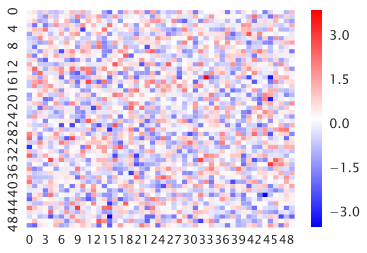

In [86]:
sns.heatmap(J_mat, cmap='bwr')

Now let's initialize a random array of neuronal states and run the Monte Carlo

In [87]:
# Initialize random state
sigma_0 = np.random.randint(0, 2, size=n_cells)

# Perform Monte Carlo
monte_carlo = ising_monte_carlo(sigma_0, h_array, J_mat, 10000)

Let's look at the time trajectories of the cells

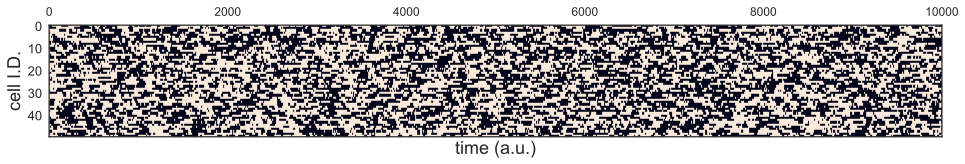

In [88]:
with sns.axes_style('white'):
    plt.matshow(monte_carlo, aspect='auto')
    plt.xlabel('time (a.u.)')
    plt.ylabel('cell I.D.')

Now let's compute the cross correlation $\left\langle \sigma_i \sigma_j \right\rangle$ from these samples.

In [89]:
# Initialize matrix to save cross correlations
cross_corr = np.empty([n_cells, n_cells])

# Loop through each of the possible pairs and save the cross correlation
for i in range(n_cells):
    for j in range(n_cells):
        cross_corr[i, j] = np.dot(monte_carlo[i, :], monte_carlo[j, :]) /\
                            monte_carlo.shape[1]

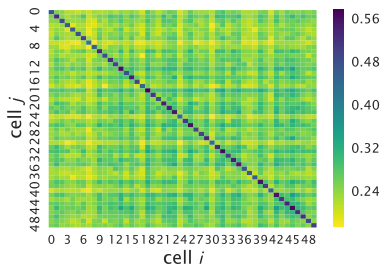

In [90]:
sns.heatmap(cross_corr, cmap='viridis_r')
plt.xlabel('cell $i$')
plt.ylabel('cell $j$')

### Block structured matrix $\mathbf{J}$

We will now try to generate a correlation matrix $\mathbf{J}$ that has a little bit of more structure. What this means is that we will take sub-blocks of the matrix and assign a specific mean and standard deviation to the that particular block.

In [114]:
# Define number of cells and the size of the block
n_cells = 100
block_length = 10
n_blocks = int(n_cells**2 / block_length**2)

# Choose the mean of the distributions for each of the blocks
block_mean = np.random.normal(loc=0, scale=3, size=n_blocks)

# Initialize N-d array that will be restructured to save blocks
J_mat = np.zeros([n_blocks, block_length, block_length])

# Loop through each of the blocks and sample the correlations
for b in range(n_blocks):
    J_mat[b, :, :] = np.random.normal(loc=block_mean[b], scale=1, 
                                      size=(block_length, block_length))

# Reshape the J_mat
J_block = 
# J_mat = J_mat.reshape([n_cells, n_cells], order='A')

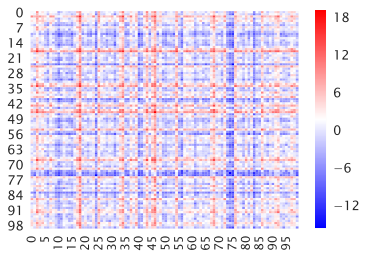

In [116]:
sns.heatmap(J_mat, cmap='bwr')